# The importance of inductive bias in convolutional models for statistical downscaling

***9th International Workshop on Climate Informatics 2019 (Paris, France)***

**J. Baño-Medina and J.M. Gutiérrez**

http://dx.doi.org/10.5065/y82j-f154

GitHub repository at https://github.com/SantanderMetGroup/DeepDownscaling

This notebook reproduces the results published in the [conference paper](https://github.com/SantanderMetGroup/DeepDownscaling/blob/master/2019_Bano_CI.pdf) titled *The importance of inductive bias in convolutional models for statistical downscaling by J. Baño-Medina and J. M. Gutiérrez, in the 9th International Workshop on Climate Informatics held in Paris in 2019. In particular, the code developed herein delves into the influence of multi-site convolitional topologies and its regularization properties. For the sake of comparison we compare this multi-site conv models with equivalent single-site architectures and classical statistical downscaling methods i.e., generalized linear models (GLM) and analogs.

Note: This notebook is written in the free programming language R and builds on the R framework [climate4R](https://github.com/SantanderMetGroup/climate4R) (C4R hereafter, conda and docker installations available), a suite of R packages developed by the [Santander Met Group](http://meteo.unican.es/en/main) for transparent climate data access, post processing (including bias correction and downscaling, via the downscaleR package; [Bedia et al. 2020](https://gmd.copernicus.org/articles/13/1711/2020/gmd-13-1711-2020-discussion.html)) and visualization. The interested reader is referred to [Iturbide et al. 2019](https://www.sciencedirect.com/science/article/abs/pii/S1364815218303049?via%3Dihub).

# 1. Loading Libraries
In this study, we build on C4R, which is used for loading and post-processing, downscaling, validation and visualization. Different sectorial [notebooks](https://github.com/SantanderMetGroup/notebooks) are available illustrating the use of C4R functions. The C4R libraries that are needed to run this notebook can be installed through the devtools package (e.g. devtools::install_github("SantanderMetGroup/loadeR") for loadeR); see detailed instructions [here](https://github.com/SantanderMetGroup/climate4R). The deep learning models used in this work are implemented in [downscaleR.keras](https://github.com/SantanderMetGroup/downscaleR.keras), an extension of downscaleR which integrates keras in the C4R.

In [2]:
library(loadeR) # version 1.6.1 
library(transformeR) # version 1.7.4
library(downscaleR) # version 3.1.3
library(visualizeR) # version 1.5.1
library(climate4R.value) # version 0.0.2 (also relies on VALUE version 2.2.1)
library(downscaleR.keras) # version 1.0.0 (relies on keras version 2.2.2 and tensorflow version 2.0.0)

library(magrittr)
library(gridExtra) # for plotting functionalities
library(RColorBrewer) # for plotting functionalities
library(sp) # for plotting functionalities

# 2. Loading Data
In this section we describe how to load into our R session the predictor and predictand datasets involved in this study; ERA-Interim, and E-OBS (version 14), respectively. In this study we rely on the [User Data Gateway (UDG)](http://meteo.unican.es/udg-tap/home), a THREDDS-based service from the Santander Climate Data Service (CDS) to load the data into our session (register [here](http://meteo.unican.es/udg-tap/signup) freely to get a user). We can log in using the `loginUDG` function from loadeR:

In [ ]:
loginUDG(username = "***", password = "***")

We find the label associated to ERA-Interim via the `UDG.datasets` function of library `loadeR`: **“ECMWF_ERA-Interim-ESD”**  (type `?UDG.datasets()` for information on the full list of datasets available at UDG). Then we load the predictors by calling `loadGridData` of `loadeR`. In particular, we load the Iberia region (IP) defined in the Prudence regions, which are stored as an object in library `visualizeR`. We then use the `lonLim` and `latLim` arguments to define the domain and `years` to load daily data for the period 1979-2008.

We loop over the `loadGridData` function to load a different predictor variable at each iteration. Since we rely on the perfect-prognosis approach of statistical downscaling models, we load those predictor variables that are reliably represented by GCMs (despite the fact in this study we only work in the observational space with reanalysis data): geopotential, specific humidity, air temperature, and the zonal and meridional wind velocities at 500, 700, 850 and 1000hPa. The code of these variables can be found by calling `C4R.vocabulary` of `loadeR`.


In [ ]:
data("PRUDENCEregions", package = "visualizeR")
bb <- PRUDENCEregions["IP"]@bbox
lonLim <- bb[1,]
latLim <- bb[2,]

variables <- c("z@500","z@700","z@850","z@1000",
               "hus@500","hus@700","hus@850","hus@1000",
               "ta@500","ta@700","ta@850","ta@1000",
               "ua@500","ua@700","ua@850","ua@1000",
               "va@500","va@700","va@850","va@1000")
x <- lapply(variables, function(x) {
  loadGridData(dataset = "ECMWF_ERA-Interim-ESD",
               var = x,
               lonLim = lonLim, 
               latLim = latLim,  
               years = 1979:2008)
}) %>% makeMultiGrid() %>% redim(drop = TRUE)

Regarding the predictand dataset, we use `loadGriData` to load into our R session the total daily rainfall amount (coded as `pr` in `C4R` vocabulary, see `?C4R.vocabulary()`) from E-OBS (version 14) at 0.5º resolution. Again, this dataset is stored in the UDG, and its label can be obtained by calling `UDG.datasets()`.
We call `binaryGrid` function of `transformeR` to convert to 0 all the daily values lower or equal than 1 mm/day. Therefore, according to this criteria, we define a rainy day whenever the rain is greater than 1mm/day.

In [ ]:
# UDG.datasets("E-OBS") # Uncomment to obtain the label of E-OBS version 14
y <- loadGridData(dataset = "E-OBS_v14_0.50regular",
                   var = "pr",lonLim = lonLim,
                   latLim = latLim, 
                   years = 1979:2008) %>% binaryGrid(condition = "GT", threshold = 1, partial = TRUE)

In the next figure we observe the Iberian Region, as defined by the Prudence regions, which is indeed our domain of study, and the predictor and predictand spatial resolutions, 2º and 0.5º, respectively. This figure can be created by using the function `spatialPlot` of `visualizeR`, and introduce the grids' coordinates as an spatial points object using the function `SpatialPoints` of base libraty `sp`.

[2021-01-08 13:05:33] - Computing climatology...

[2021-01-08 13:05:33] - Done.



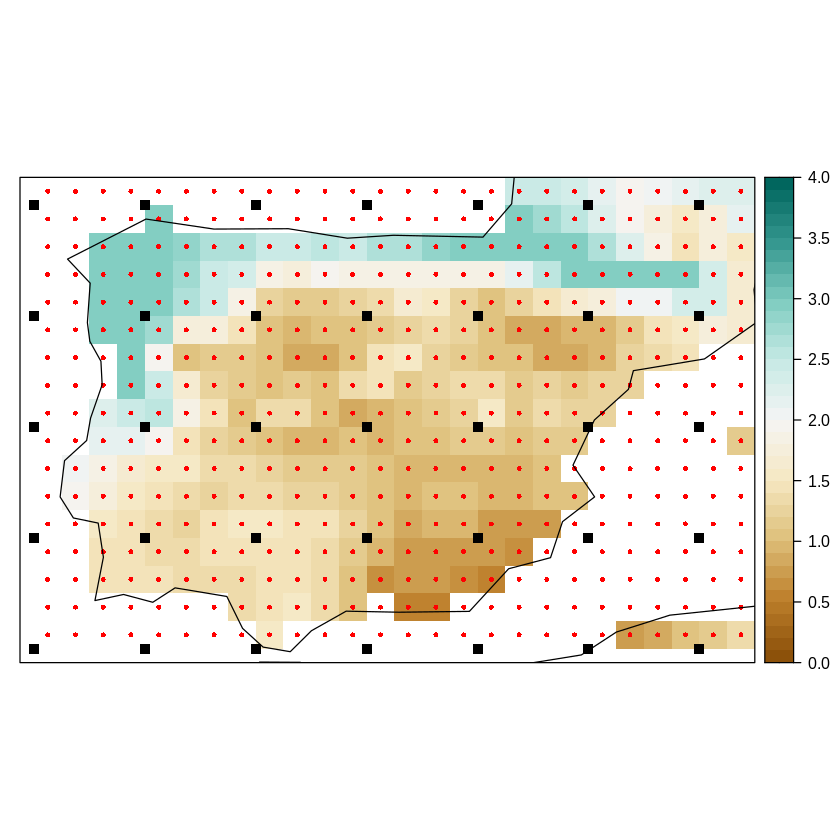

In [6]:
areas <- PRUDENCEregions
n <- names(PRUDENCEregions)
n_regions <- length(n)
coords_x <- expand.grid(x$xyCoords$x,x$xyCoords$y) ; names(coords_x) <- c("x","y")
coords_y <- expand.grid(y$xyCoords$x,y$xyCoords$y) ; names(coords_y) <- c("x","y")
spatialPlot(climatology(y),at = seq(0, 4, 0.1), set.min = 0, set.max = 3, 
            ylim = c(35.75,44.5), xlim = c(-10.25,3),
            backdrop.theme = "coastline", 
            col.regions = colorRampPalette(brewer.pal(n = 9, "BrBG")),
            sp.layout = list(list(SpatialPoints(coords_x), first = FALSE, 
                                  col = "black", pch = 15, cex = 1),
                             list(SpatialPoints(coords_y), first = FALSE, 
                                  col = "red", pch = 16, cex = 0.5)),
            colorkey = TRUE)

# 3. Downscaling
In this section we develop the code to build all the downscaling methods intercompared in this study. We build on downscaleR and downscaleR.keras libraries to build the generalized linear models and the nearest-neighbour search (i.e., analogs), and finally the deep learning models, respectively.

To validate the models we perform a 5-fold cross-validation, i.e., there are 5 models in total for every downscaling method. In particular we define the following chronological folds and store them in an R object.

In [7]:
folds <- list(1979:1984,
              1985:1990,
              1991:1996,
              1997:2002,
              2003:2008)

## 3.1 Benchmark methods (GLM and analogs)
In this subsection we develop the GLMs and analogs downscaling methods building on downscaleR. Due to the discrete-continuous nature of precipitation, we build 2 GLMs --a logistic regression and a Gamma regression with link logarithmic, -- that focus on the prediction of the occurrence of precipitation and on the amount of precipitation, respectively. For each location, we limit the predictor space to its 4 closest gridpoints, to avoid high-dimensionality spaces that lead to overfitting.

This 2-phase downscaling is not required for analogs, which basically looks for the closest neighbour based on a moving window of 25 neighbours at every site.

### 3.1.1 GLM (Logistic Regression)
We use the `downscaleCV` to perform the cross-validation for the logistic regresssion. Note that we specify the folds and predictor configuratios (e.g., standardization) via the `downsaleCV` arguments, type `?downsaleCV` for more information. We define the logistic regression by building a GLM (`method = "GLM"`) and familiy binomial with link logit (`family = binomial(link = "logit")`). Due to the high-computational cost of building a GLM model for each predictand location, we iterate over the latitude dimension and then bind the results by calling `bindGrid` of `transformeR`.

Finally, we store in 2 different objects the probabilities of rain (`glm.ocu`) and the binary precipitation (`glm.bin`) thanks to `subsetGrid` of `transformeR`.

In [ ]:
y_bin <- binaryGrid(y, condition = "GT", threshold = 1)
glm.ocubin <- lapply(1:getShape(y,"lat"),FUN = function(z) {
  downscaleCV(x,subsetDimension(y_bin,dimension = "lat",indices = z),
              folds = folds,
              method = "GLM", family = binomial(link = "logit"),
              scaleGrid.args = list(type = "standardize"),
              prepareData.args = list(local.predictors = list(n = 4, vars = getVarNames(x)))
  ) 
}) %>% bindGrid(dimension = "lat")
glm.ocu <- subsetGrid(glm.ocubin,var = "prob")
glm.bin <- subsetGrid(glm.ocubin,var = "bin")

### 3.1.2 GLM (Gamma Regression)
We repeat the process as for the logistic regression but changing to a Gamma regression defined as `family = Gamma(link = "log")` as one of the `downscaleCV` arguments. To center the Gamma on 0, we substract 1mm to the serie and only train with the wet days at each location. After the prediction we call `gridArithmetics` from `transformeR` to elminate this artificial bias of 1mm.

In [ ]:
y_rest <- gridArithmetics(y,1,operator = "-")
glm.amo <- lapply(1:getShape(y,"lat"),FUN = function(z) {
  downscaleCV(x,subsetDimension(y_rest,dimension = "lat",indices = z),
              folds = folds,
              method = "GLM", family = Gamma(link = "log"),
              condition = "GT", threshold = 0,
              scaleGrid.args = list(type = "standardize"),
              prepareData.args = list(local.predictors = list(n = 4, vars = getVarNames(x)))
  ) 
}) %>% bindGrid(dimension = "lat") %>% redim(drop = TRUE) %>% gridArithmetics(1,operator = "+")
glm <- gridArithmetics(subsetGrid(glm.bin,var = "bin"),glm.amo,operator = "*")

### 3.1.3 Analogs
Similar to the GLMs, in this case we change the method to analogs by changin the parameter `method` in `downscaleCV`.

In [ ]:
ana <- lapply(1:getShape(y,"lat"),FUN = function(z) {
  print(z)
  downscaleCV(x,subsetDimension(y,dimension = "lat",indices = z),
              folds = folds,
              method = "analogs", n.analogs = 1,
              scaleGrid.args = list(type = "standardize"),
              prepareData.args = list(local.predictors = list(n = 25, vars = getVarNames(x)))
  ) 
}) %>% bindGrid(dimension = "lat") %>% redim(drop = TRUE) 
save(ana, file = "analogs.rda")

## 3.2 Downscaling - Deep Neural Networks
In this section we develop the deep learning topologies based on the library `downscaleR.keras`. In particular, we develop the CNN1 model studied in a [recent publication](https://doi.org/10.5194/gmd-2019-278) in the *Geoscientific and Model Development* journal.

### 3.2.1 CNN single-site (CNN-SS)
We build two loops that iterate over the latitude and longitude dimensions, to build single-site versions of the CNN1 model at each latitude-longitude predictand gridpoint. This subsetting is performer with `subsetDimension` of `transformeR`. The CNN1 topology, is defined and stored as a `keras` object in `model`. We then call the function `downscaleCV.keras` of `downscaleR.keras` with the model already defined and optimize it by minimizing the negative log-likelihood of a Bernouilli-Gamma distribution, custom loss function `bernouilliGammaLoss` in `downscaleR.keras`. This optimization phase is done with an Adam optimizer and a learning rate of 0.0001 with an early-stopping criteria of 30 apochs of patience. This function returns the parameters of this Bernouilli-Gamma distribution which are further passed to `downscaleR.keras` function `computeRainfall` to compute the expectance of the conditional daily Gamma distributions and therefore return the amount of rainfall for a given day.

We store all the predictions temporal series in 4 differenct objects: the probability of rain (`cnnss.ocu`), the no rain/rain serie (`cnnss.bin`), the amount of rain (`cnnss.amo`), and the recovered temporal serie (`cnnss`) which is the result of a multiplication between `cnnss.bin` and `cnnss.amo`.

In [ ]:
pred <- lapply(1:getShape(y,"lat"), FUN = function(z) {
  y <- subsetDimension(y,dimension = "lat",indices = z)
  pred <- lapply(1:getShape(y,"lon"), FUN = function(zz) {
    y <- subsetDimension(y,dimension = "lon",indices = zz) %>% gridArithmetics(0.99,operator = "-") %>% binaryGrid("GT",0,partial = TRUE)
    print(paste(z,"_",zz))
    if (all(is.na(y$Data))) {
      pred <- makeMultiGrid(y,y,y,y)
      pred$Variable$varName <- c("bin","p","amo","pr")  
    }  else {
      inputs <- layer_input(shape = c(getShape(x,"lat"),getShape(x,"lon"),getShape(x,"var")))
      l0 = inputs
      l1 = layer_conv_2d(l0 ,filters = 50, kernel_size = c(3,3), activation = 'relu', padding = "same")
      l2 = layer_conv_2d(l1,filters = 25, kernel_size = c(3,3), activation = 'relu', padding = "same")
      l3 = layer_conv_2d(l2,filters = 1, kernel_size = c(3,3), activation = 'relu', padding = "same")
      l4 = layer_flatten(l3)
      parameter1 = layer_dense(l4,units = 1, activation = "sigmoid")
      parameter2 = layer_dense(l4,units = 1)
      parameter3 = layer_dense(l4,units = 1)
      outputs = layer_concatenate(list(parameter1,parameter2,parameter3))
      model <- keras_model(inputs = inputs, outputs = outputs)
      pred <- downscaleCV.keras(x,y,model,
                                folds = list(1979:1984,1985:1990,1991:1996,1997:2002,2003:2008),
                                prepareData.keras.args = list(first.connection = "conv", last.connection = "dense", channels = "last"),              
                                scaleGrid.args = list("type" = "standardize"),
                                compile.args = list(loss = bernouilliGammaLoss(last.connection = "dense"), optimizer = optimizer_adam(lr = 0.0001)),
                                fit.args = list(batch_size = 100, epochs = 10000, validation_split = 0.1,verbose = 1,
                                                callbacks = list(callback_early_stopping(patience = 30))),
                                loss = "bernouilliGammaLoss",binarySerie = TRUE,condition = "GE",threshold = 1) 
      k_clear_session(); rm(model)
      pred_amo <- computeRainfall(log_alpha = subsetGrid(pred,var = "log_alpha"),
                                  log_beta = subsetGrid(pred,var = "log_beta"),
                                  bias = 0.99)
      pred_bin <- subsetGrid(pred, var = "bin")  
      pred_serie <- gridArithmetics(pred_amo,pred_bin)
      pred_amo$Variable$varName <- "amo"
      pred <- makeMultiGrid("bin" = pred_bin, "pro" = subsetGrid(pred, var = "p"),"amo" = pred_amo, "serie" = pred_serie)
      pred$Dates <- makeMultiGrid(y,y,y,y)$Dates  
    }
    pred    
  }) %>% bindGrid(dimension = "lon")    
}) %>% bindGrid(dimension = "lat")
cnnss.ocu <- subsetGrid(pred, var = "p")
cnnss.bin <- subsetGrid(pred, var = "bin")
cnnss.amo <- subsetGrid(pred, var = "amo")
cnnss <- subsetGrid(pred, var = "pr")
save(cnnss.ocu,cnnss.bin,cnnss.amo,cnnss, file = "cnn-ss.rda")

###  3.2.2 CNN multi-site (CNN-MS)
In this section we build the CNN1 model, in a multi-site topology, only for those gridpoints located over land, as the E-OBS dataset do not contain data for sea-gridpoints. The model is stored as a `keras` object.

In [ ]:
landGP <- apply(y$Data,MARGIN = c(2,3),FUN = function(z) !anyNA(z)) %>% sum()
inputs <- layer_input(shape = c(getShape(x,"lat"),getShape(x,"lon"),getShape(x,"var")))
l0 = inputs
l1 = layer_conv_2d(l0 ,filters = 50, kernel_size = c(3,3), activation = 'relu', padding = "same")
l2 = layer_conv_2d(l1,filters = 25, kernel_size = c(3,3), activation = 'relu', padding = "same")
l3 = layer_conv_2d(l2,filters = 1, kernel_size = c(3,3), activation = 'relu', padding = "same")
l4 = layer_flatten(l3)
parameter1 = layer_dense(l4,units = landGP, activation = "sigmoid")
parameter2 = layer_dense(l4,units = landGP)
parameter3 = layer_dense(l4,units = landGP)
outputs = layer_concatenate(list(parameter1,parameter2,parameter3))
model <- keras_model(inputs = inputs, outputs = outputs)

We then input this model in the `downscaleCV.keras` function similar to the CNN-SS and then stored the 3 prediction temporal series in `cnnms.ocu`, `cnnms.bin` and `cnnms.amo` and `cnnms`.

In [ ]:
y_rest <- gridArithmetics(y,0.99,operator = "-") %>% binaryGrid("GT",0,partial = TRUE) 
pred <- downscaleCV.keras(x,y_rest,model,
            folds = list(1979:1984,1985:1990,1991:1996,1997:2002,2003:2008),
            prepareData.keras.args = list(first.connection = "conv", last.connection = "dense", channels = "last"),              
            scaleGrid.args = list("type" = "standardize"),
            compile.args = list(loss = bernouilliGammaLoss(last.connection = "dense"), optimizer = optimizer_adam(lr = 0.0001)),
            fit.args = list(batch_size = 100, epochs = 1, validation_split = 0.1, verbose = 1,
                                callbacks = list(callback_early_stopping(patience = 30))),
            loss = "bernouilliGammaLoss",binarySerie = TRUE,condition = "GE",threshold = 1)  
pred_amo <- computeRainfall(log_alpha = subsetGrid(pred,var = "log_alpha"),
                            log_beta = subsetGrid(pred,var = "log_beta"),
                            bias = 0.99)
cnnms.ocu <- subsetGrid(pred, var = "p")
cnnms.bin <- subsetGrid(pred, var = "bin")
cnnms.amo <- pred_amo
cnnms <- gridArithmetics(cnnms.amo,cnnms.bin)
save(cnnms.ocu,cnnms.bin,cnnms.amo,cnnms, file = "cnn-ms.rda")

# 4. Validation of the Results
In this figure, we calculate the validation indices by using the library `climate4R.value` of `climate4R`. In particular the indices used are: the Roc Skill Score (ROCSS), the Root Mean Squared Error (RMSE), the spearman correlation and the relative biases of the climatology, and are used for each of the folds independently.

In [10]:
y_bin <- binaryGrid(y, condition = "GT", threshold = 1)
rocss.ana <- rocss.glm <- rocss.cnnss <- rocss.cnnms <- vector(mode = "numeric", length = length(folds))
rmse.ana <- rmse.glm <- rmse.cnnss <- rmse.cnnms <- vector(mode = "numeric", length = length(folds))
corr.ana <- corr.glm <- corr.cnnss <- corr.cnnms <- vector(mode = "numeric", length = length(folds))
bias.ana <- bias.glm <- bias.cnnss <- bias.cnnms <- vector(mode = "numeric", length = length(folds))
for (i in 1:length(folds)) {
  rocss.ana[i] <- valueMeasure(subsetGrid(y_bin,years = folds[[i]]),
                               subsetGrid(ana,years = folds[[i]]),
                               measure.code="ts.rocss")$Measure$Data %>% mean(na.rm = TRUE) %>%
    round(digits = 2)
  rocss.glm[i] <- valueMeasure(subsetGrid(y_bin,years = folds[[i]]),
                               subsetGrid(glm.ocu,years = folds[[i]]),
                               measure.code="ts.rocss")$Measure$Data %>% mean(na.rm = TRUE) %>%
    round(digits = 2)
  rocss.cnnss[i] <- valueMeasure(subsetGrid(y_bin,years = folds[[i]]),
                                subsetGrid(cnnss.ocu,years = folds[[i]]),
                                measure.code="ts.rocss")$Measure$Data %>% mean(na.rm = TRUE) %>%
    round(digits = 2)
  rocss.cnnms[i] <- valueMeasure(subsetGrid(y_bin,years = folds[[i]]),
                                subsetGrid(cnnms.ocu,years = folds[[i]]),
                                measure.code="ts.rocss")$Measure$Data %>% mean(na.rm = TRUE) %>%
    round(digits = 2)
  
  rmse.ana[i] <- valueMeasure(subsetGrid(y,years = folds[[i]]),
                              subsetGrid(ana,years = folds[[i]]),
                              measure.code="ts.RMSE")$Measure$Data %>% mean(na.rm = TRUE) %>%
    round(digits = 2)
  rmse.glm[i] <- valueMeasure(subsetGrid(y,years = folds[[i]]),
                              subsetGrid(glm.amo,years = folds[[i]]),
                              measure.code="ts.RMSE")$Measure$Data %>% mean(na.rm = TRUE) %>%
    round(digits = 2)
  rmse.cnnss[i] <- valueMeasure(subsetGrid(y,years = folds[[i]]),
                               subsetGrid(cnnss.amo,years = folds[[i]]),
                               measure.code="ts.RMSE")$Measure$Data %>% mean(na.rm = TRUE) %>%
    round(digits = 2)
  rmse.cnnms[i] <- valueMeasure(subsetGrid(y,years = folds[[i]]),
                               subsetGrid(cnnms.amo,years = folds[[i]]),
                               measure.code="ts.RMSE")$Measure$Data %>% mean(na.rm = TRUE) %>%
    round(digits = 2)
  
  corr.ana[i] <- valueMeasure(subsetGrid(y,years = folds[[i]]),
                              subsetGrid(ana,years = folds[[i]]),
                              measure.code="ts.rs")$Measure$Data %>% mean(na.rm = TRUE) %>%
    round(digits = 2)
  corr.glm[i] <- valueMeasure(subsetGrid(y,years = folds[[i]]),
                              subsetGrid(glm,years = folds[[i]]),
                              measure.code="ts.rs")$Measure$Data %>% mean(na.rm = TRUE) %>%
    round(digits = 2)
  corr.cnnss[i] <- valueMeasure(subsetGrid(y,years = folds[[i]]),
                               subsetGrid(cnnss,years = folds[[i]]),
                               measure.code="ts.rs")$Measure$Data %>% mean(na.rm = TRUE) %>%
    round(digits = 2)
  corr.cnnms[i] <- valueMeasure(subsetGrid(y,years = folds[[i]]),
                               subsetGrid(cnnms,years = folds[[i]]),
                               measure.code="ts.rs")$Measure$Data %>% mean(na.rm = TRUE) %>%
    round(digits = 2)
  
  bias.ana[i] <- valueMeasure(subsetGrid(y,years = folds[[i]]), 
                              subsetGrid(ana,years = folds[[i]]), 
                              measure.code="biasRel",index.code="Mean")$Measure$Data %>% 
    mean(na.rm = TRUE) %>% 
    round(digits = 2) 
  bias.glm[i] <- valueMeasure(subsetGrid(y,years = folds[[i]]), 
                              subsetGrid(glm,years = folds[[i]]), 
                              measure.code="biasRel",index.code="Mean")$Measure$Data %>% 
    mean(na.rm = TRUE) %>% 
    round(digits = 2) 
  bias.cnnss[i] <- valueMeasure(subsetGrid(y,years = folds[[i]]), 
                               subsetGrid(cnnss,years = folds[[i]]), 
                               measure.code="biasRel",index.code="Mean")$Measure$Data %>% 
    mean(na.rm = TRUE) %>% 
    round(digits = 2) 
  bias.cnnms[i] <- valueMeasure(subsetGrid(y,years = folds[[i]]), 
                               subsetGrid(cnnms,years = folds[[i]]), 
                               measure.code="biasRel",index.code="Mean")$Measure$Data %>% 
    mean(na.rm = TRUE) %>% 
    round(digits = 2) 
} 

[2021-01-13 09:53:35] Computing member 1 out of 1

[2021-01-13 09:53:38] Done.

[2021-01-13 09:53:38] Computing member 1 out of 1

[2021-01-13 09:53:42] Done.

[2021-01-13 09:53:43] Computing member 1 out of 1

[2021-01-13 09:53:47] Done.

[2021-01-13 09:53:48] Computing member 1 out of 1

[2021-01-13 09:53:52] Done.

[2021-01-13 09:53:52] Computing member 1 out of 1

[2021-01-13 09:53:53] Done.

[2021-01-13 09:53:54] Computing member 1 out of 1

[2021-01-13 09:53:56] Done.

[2021-01-13 09:53:56] Computing member 1 out of 1

[2021-01-13 09:53:57] Done.

[2021-01-13 09:53:58] Computing member 1 out of 1

[2021-01-13 09:53:59] Done.

[2021-01-13 09:54:00] Computing member 1 out of 1

[2021-01-13 09:54:02] Done.

[2021-01-13 09:54:03] Computing member 1 out of 1

[2021-01-13 09:54:05] Done.

[2021-01-13 09:54:05] Computing member 1 out of 1

[2021-01-13 09:54:07] Done.

[2021-01-13 09:54:08] Computing member 1 out of 1

[2021-01-13 09:54:10] Done.

[2021-01-13 09:54:10] Computing member 1

[2021-01-13 09:56:48] Done.

[2021-01-13 09:56:49] Computing member 1 out of 1

[2021-01-13 09:56:50] Done.

[2021-01-13 09:56:50] Computing member 1 out of 1

[2021-01-13 09:56:52] Done.

[2021-01-13 09:56:53] Computing member 1 out of 1

[2021-01-13 09:56:54] Done.

[2021-01-13 09:56:55] Computing member 1 out of 1

[2021-01-13 09:56:56] Done.

[2021-01-13 09:56:57] Computing member 1 out of 1

[2021-01-13 09:56:58] Done.

[2021-01-13 09:56:59] Computing member 1 out of 1

[2021-01-13 09:57:00] Done.

[2021-01-13 09:57:00] Computing member 1 out of 1

[2021-01-13 09:57:02] Done.

[2021-01-13 09:57:02] Computing member 1 out of 1

[2021-01-13 09:57:03] Done.

[2021-01-13 09:57:03] Computing member 1 out of 1

[2021-01-13 09:57:04] Done.

[2021-01-13 09:57:04] Computing member 1 out of 1

[2021-01-13 09:57:05] Done.

[2021-01-13 09:57:05] Computing member 1 out of 1

[2021-01-13 09:57:06] Done.

[2021-01-13 09:57:07] Computing member 1 out of 1

[2021-01-13 09:57:08] Done.

[2021-01-13

We can easily plot the results using the base R function `plot`.

[2021-01-13 11:05:02] Computing member 1 out of 1

[2021-01-13 11:05:03] Done.

[2021-01-13 11:05:04] Computing member 1 out of 1

[2021-01-13 11:05:06] Done.

[2021-01-13 11:05:07] Computing member 1 out of 1

[2021-01-13 11:05:08] Done.

[2021-01-13 11:05:09] Computing member 1 out of 1

[2021-01-13 11:05:11] Done.

[2021-01-13 11:05:12] Computing member 1 out of 1

[2021-01-13 11:05:13] Done.



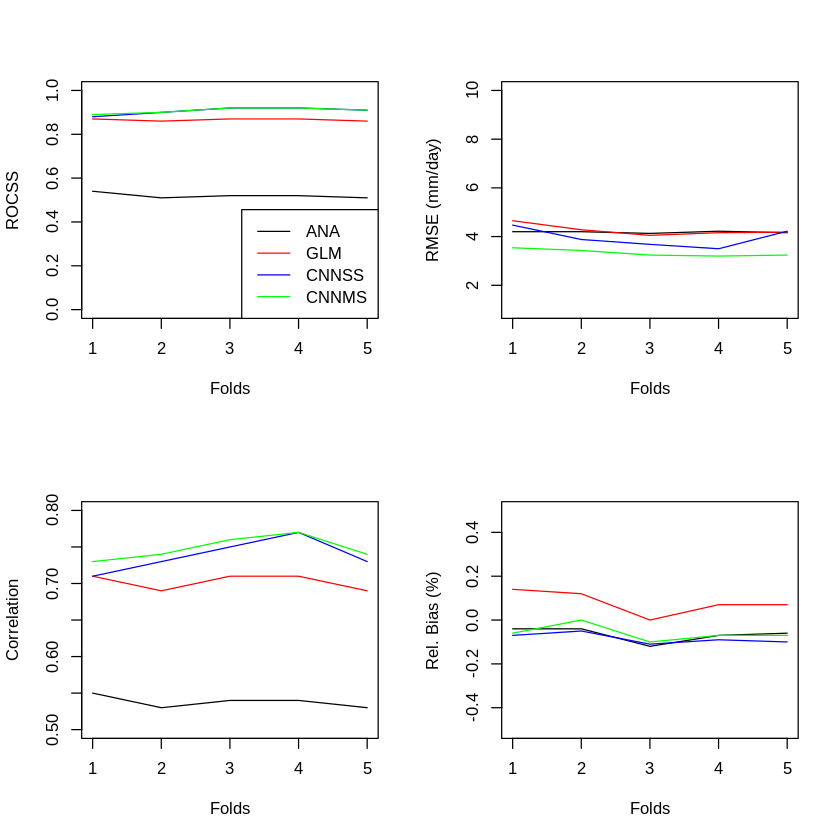

In [69]:
par(mfrow = c(2,2))
# ROCSS
plot(rocss.ana, type = "l", col = "black", xlab = "Folds", ylab = "ROCSS", ylim = c(0,1))
lines(rocss.glm, col = "red")
lines(rocss.cnnss, col = "blue")
lines(rocss.cnnms, col = "green")
legend("bottomright", legend = c("ANA","GLM","CNNSS","CNNMS"), col = c("black","red","blue","green"), lty = c(1,1,1,1))

# RMSE
plot(rmse.ana, type = "l", col = "black", xlab = "Folds", ylab = "RMSE (mm/day)", ylim = c(1,10))
lines(rmse.glm, col = "red")
lines(rmse.cnnms, col = "green")
rmse.cnnssMasked <- c()
for (i in 1:length(folds)) {
    rmse <- valueMeasure(subsetGrid(y,years = folds[[i]]),subsetGrid(cnnss.amo,years = folds[[i]]),measure.code="ts.RMSE")$Measure$Data
    rmse.cnnssMasked[i] <- rmse[which(rmse <= 10, arr.ind = TRUE)] %>% mean(na.rm = TRUE) %>% round(digits = 2) 
}
lines(rmse.cnnssMasked, col = "blue")

# CORRELATION
plot(corr.ana, type = "l", col = "black", xlab = "Folds", ylab = "Correlation", ylim = c(0.5,0.8))
lines(corr.glm, col = "red")
lines(corr.cnnss, col = "blue")
lines(corr.cnnms, col = "green")

# Relative bias
plot(bias.ana, type = "l", col = "black", xlab = "Folds", ylab = "Rel. Bias (%)", ylim = c(-0.5,0.5))
lines(bias.glm, col = "red")
lines(bias.cnnss, col = "blue")
lines(bias.cnnms, col = "green")

We see very high RMSE for the CNN-SS model (>100 mm/day), if we do not mask certain gridpoints. We can take a deeper look at the results by analyzing the number of gridpoints with extremely high RMSE. These gridpoints would have suffered overfitting whereas multi-task architectures solve this instability for these gridpoints.

In [51]:
rmse <- valueMeasure(y,cnnss.amo,measure.code="ts.RMSE")$Measure$Data %>% round(digits = 2)
print(paste0("The fraction of gridpoints with an unstable behaviour is: ", round(sum(rmse > 10,na.rm = TRUE)/sum(!is.na(rmse),na.rm = TRUE), digits = 2)*100, "%"))

[2021-01-13 10:40:10] Computing member 1 out of 1

[2021-01-13 10:40:13] Done.



[1] "The fraction of gridpoints with an unstable behaviour is: 5%"


We can visualize where these 5% of the gridpoints are located by calling the function `spatialPlot`.

[2021-01-13 10:58:24] Computing member 1 out of 1

[2021-01-13 10:58:27] Done.



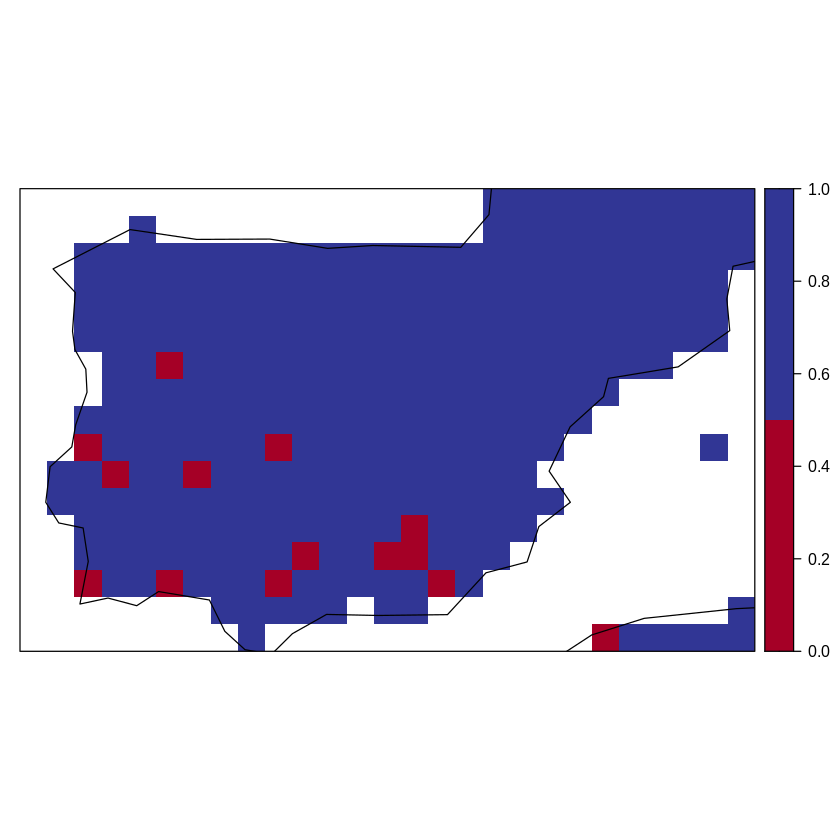

In [67]:
rmse <- valueMeasure(y,cnnss.amo,measure.code="ts.RMSE")$Measure
rmse$Data[which(rmse$Data <= 10, arr.ind = TRUE)] <- 1
rmse$Data[which(rmse$Data > 10, arr.ind = TRUE)] <- 0
attr(rmse$Data,"dimensions") <- c("lat","lon")
spatialPlot(rmse, backdrop.theme = "coastline", at = seq(0,1,length.out = 3), set.min = 0, set.max = 1)